Given the same dataset,

- extract the most syntactically weighted N-grams, omitting nonsense (‘казалось бы’, ‘возможно предположить’, etc). The main idea is to extract the most valuable data from the text.

- Try different models for a topic extraction. Which one performs better? What metrics were used to evaluate the model?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import re
import multiprocessing as mp
from string import punctuation
import gensim

Load data:

In [2]:
lenta_data = pd.read_csv('E:/PycharmProjects/data/lenta-ru-news.csv')
lenta_data.head()

c:\program files\python38\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


Clean and preprocessing text data:

In [3]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ситилинк\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
import re, string
from nltk.stem.snowball import SnowballStemmer

russian_stopwords = stopwords.words("russian")
regex = re.compile('[%s]' % re.escape(string.punctuation))
stemmer = SnowballStemmer("russian") 

def preprocessing(text):
    text = regex.sub('', text)
    text = [token for token in text.split() if token not in russian_stopwords]
    text = [stemmer.stem(token) for token in text] 
    text = [token for token in text if token] 
    return ' '.join(text)

Only 10 000 values from dataset, bcs original dataset is very big and process it take a lot of time:

In [9]:
lenta_data['text'][:10000] = lenta_data['text'][:10000].apply(lambda x: preprocessing(x))

In [12]:
preprocessing_data = pd.DataFrame({'text': lenta_data['text'][:10000]})
preprocessing_data

,text
0,бо сопоцкин друскеник законч отступл германц н...
1,министерств народн просвещ вид происход чрезвы...
2,штабскап п н нестер днях увид район желт галиц...
3,фотографкорреспондент Daily Mirror рассказ слу...
4,лиц приех варш люблин туд доставл «швабск звер...
...,...
9995,глав мвд дагест приказ наряд милиц приграничн ...
9996,представител кремл ведут активн диалог губерна...
9997,москв 20 июл открыв фестива планет клоунад смо...
9998,чист американск получ фин уимблдонск теннисн т...


Create the bigrams and trigrams, using gensim:

In [16]:
text = []
for index, row in preprocessing_data.iterrows():
        text.append(row['text'].split())

from gensim.models import Phrases
bigram = Phrases(text) 
trigram = Phrases(bigram[text])

for idx in range(len(text)):
    for token in bigram[text[idx]]:
        if '_' in token:
            text[idx].append(token)
    for token in trigram[text[idx]]:
        if '_' in token:
            text[idx].append(token)

Create the bigrams, using nltk:

In [22]:
texts = []
for index, row in preprocessing_data.iterrows():
        texts.append(row['text'].split())
        
from nltk.util import ngrams
import  collections

bigrams = [ngrams(text, 2) for text in texts]
bigram_freq = [collections.Counter(bigram) for bigram in bigrams]
# look at the most popular bigrams in the third and fourth text
bigram_freq[2].most_common(5), bigram_freq[3].most_common(5)

([(('лиш', 'птиц'), 4),
  (('нестер', 'погиб'), 2),
  (('сентябр', '1914'), 2),
  (('1914', 'год'), 2),
  (('безбрежн', 'неб'), 2)],
 [(('фотографкорреспондент', 'Daily'), 1),
  (('Daily', 'Mirror'), 1),
  (('Mirror', 'рассказ'), 1),
  (('рассказ', 'случ'), 1),
  (('случ', 'котор'), 1)])

Create LDA-model

In [23]:
from gensim.corpora.dictionary import Dictionary
from numpy import array

dictionary = Dictionary(text)
dictionary.filter_extremes(no_below=10, no_above=0.1)

corpus = [dictionary.doc2bow(doc) for doc in text]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus))

Количество уникальных токенов: 7792
Количество документов: 10000


In [25]:
from gensim.models.ldamulticore import LdaMulticore

model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = 10)
model.show_topics()

[(0,
  '0.004*"боевик" + 0.003*"войск" + 0.003*"северн" + 0.003*"группировк" + 0.003*"грозн" + 0.003*"объедин" + 0.003*"заявл" + 0.003*"чеченск" + 0.002*"республик" + 0.002*"путин"'),
 (1,
  '0.004*"цен" + 0.004*"нефт" + 0.003*"боевик" + 0.003*"международн" + 0.002*"обвин" + 0.002*"жител" + 0.002*"чеченск" + 0.002*"рубл" + 0.002*"вооруж" + 0.002*"банк"'),
 (2,
  '0.006*"процент" + 0.003*"боевик" + 0.003*"втор" + 0.003*"грозн" + 0.003*"войск" + 0.002*"официальн" + 0.002*"област" + 0.002*"акц" + 0.002*"территор" + 0.002*"выбор"'),
 (3,
  '0.004*"выбор" + 0.003*"путин" + 0.003*"кандидат" + 0.003*"банк" + 0.003*"интернет" + 0.003*"встреч" + 0.003*"депутат" + 0.003*"бывш" + 0.002*"сист" + 0.002*"закон"'),
 (4,
  '0.003*"боевик" + 0.003*"взрыв" + 0.003*"председател" + 0.003*"банк" + 0.003*"операц" + 0.003*"процент" + 0.003*"област" + 0.003*"путин" + 0.003*"выбор" + 0.002*"депутат"'),
 (5,
  '0.006*"сайт" + 0.003*"интернет" + 0.003*"мир" + 0.003*"акц" + 0.003*"выбор" + 0.002*"налог" + 0.002*"

We need to define the optimal numbers of topics:

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def calc_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values = calc_coherence_values(dictionary = dictionary, corpus=corpus, texts=text, start = 2, limit = 50, step = 2)

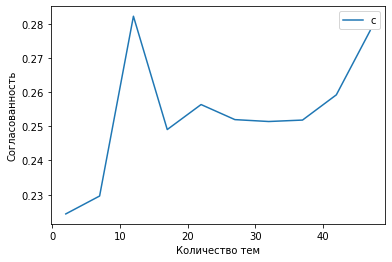

In [39]:
limit, start, step = 50, 2, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.show()

The best coherence - for ~14 topics.

Now, save  model:

In [40]:
model_list[12].save('model/best_model.lda')

from gensim import corpora

corpora.Dictionary.save(dictionary, "model/dictionary.dict")
corpora.BleiCorpus.save_corpus(fname="model/corpus.lda-c",corpus= corpus)
bigram.save('./model/bigram.phs')
trigram.save('./model/trigram.phs')

IndexError: list index out of range